# 4.2. 자기지도학습과 준지도학습(Self-supervised Learning and Semi-supervised Learning)

- 작성자: [김찬란](https://github.com/seriousran)

## 4.2.1 오토인코더

In [0]:
# 코드 4-10 오토인코더 생성 함수

from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 32

def create_encoder():
  inputs = Input(shape=(784,))
  encoder = Model(inputs, encoded)

  return encoder

def create_decoder():
  encoded_input = Input(shape=(encoding_dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder_layer(encoded_input))

  return decoder

def create_autoencoder():
  inputs = Input(shape=(784,))
  encoded = Dense(encoding_dim, activation='relu')(input)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(input, output)

  return autoencoder

## 4.2.2. 사기성 신용카드 거래 검출 문제 - 오토인코더를 활용한 준지도학습 분류

In [0]:
# 코드 4-11 임포트 및 데이터 불러오기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv("drive/My Drive/colab/creditcardfraud/creditcard.csv")
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
# 코드 4-12 클래스 계수

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## 4.2.3 t-SNE를 이용한 데이터 시각화

In [0]:
# 코드 4-13 데이터 샘플링

vis_df = df[df['Class'] == 0].sample(4428)
vis_df = vis_df.append(df[df['Class'] == 1])
vis_df = vis_df.reset_index(drop=True)
vis_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,20.305833,-1.168778,0.702367,1.880884,0.036235,-0.670265,0.229152,-0.375825,0.802299,0.454598,-0.794004,-2.072235,-1.012181,-1.657997,0.097985,0.290583,0.474527,-0.143242,0.486469,0.498622,0.012761,-0.101099,-0.323568,-0.239411,-0.464140,0.310601,0.425963,0.157033,0.044848,25.50,0
1,21.341389,-1.903612,1.970522,0.558809,1.176187,-0.776806,0.947335,-1.409366,-3.177244,-0.143214,0.331783,1.057979,0.713326,-1.477578,0.961372,0.067744,-0.484141,0.792995,0.026154,0.670490,-0.979839,3.735682,-1.402946,0.536048,0.106231,-0.199461,-0.362565,0.460171,-0.005787,32.70,0
2,21.198889,1.114906,-0.150266,0.724957,0.736345,-0.623124,0.000408,-0.379310,0.254248,0.462181,-0.045708,1.216492,0.598878,-1.546455,0.396136,-0.450010,-0.276023,0.177934,-0.574753,0.083823,-0.226811,-0.219925,-0.543337,0.133155,0.215860,0.159222,0.184249,-0.012041,0.003278,9.99,0
3,20.621389,-0.957030,0.632202,2.678390,-1.250640,0.241898,-0.124943,0.703408,0.067336,-0.357318,-0.834045,1.591433,0.799848,-0.003273,-0.172500,-0.317103,0.860482,-1.149985,-0.230797,-1.968696,-0.129849,0.006708,0.034001,-0.230220,0.213241,0.156855,-0.058815,-0.172214,-0.175291,9.44,0
4,8.529167,1.794773,-0.412593,0.211905,1.314712,-0.848138,0.055662,-0.800224,0.211246,0.912056,0.290839,0.828427,1.099098,0.032289,-0.002855,-0.013830,0.683237,-0.931397,0.647249,-0.495443,-0.168178,0.138670,0.453645,0.249089,-0.025172,-0.410739,-0.778498,0.070511,-0.023085,45.00,0


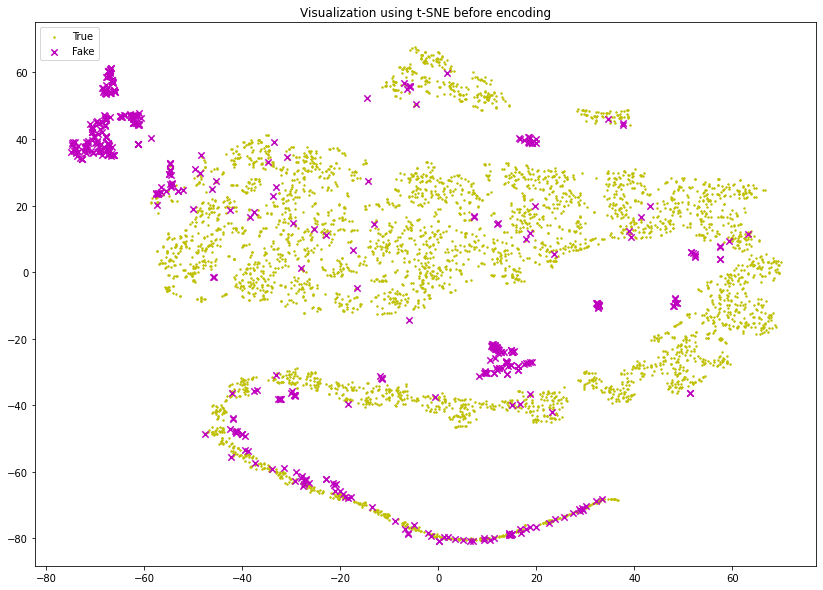

In [0]:
# 코드 4-14 t-SNE를 활용한 시각화

tsne = TSNE(n_components = 2, method = 'barnes_hut', random_state=2020)
result_tsne = tsne.fit_transform(vis_df.values)

idx_cls_z = vis_df[vis_df['Class']==0].index.values
idx_cls_o = vis_df[vis_df['Class']==1].index.values

fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(result_tsne[idx_cls_z][:,1], result_tsne[idx_cls_z][:,0], s = 2, marker= 'o', c='y')
plt.scatter(result_tsne[idx_cls_o][:,1], result_tsne[idx_cls_o][:,0], s = 40, marker= 'x', c='m')
plt.legend(['True', 'Fake'], loc='upper left')  
plt.title('Visualization using t-SNE before encoding');

## 4.2.4 AutoEncoder를 이용한 특징 표현 학습

In [0]:
# 코드 4-15 준지도학습을 위한 데이터 추출

x_normal = df[df['Class'] == 0].drop('Class', axis=1).values[0:2843]
x_fraud = df[df['Class'] == 1].drop('Class', axis=1).values

REP_DIM = 50

In [0]:
# 코드 4-16 오토인코더 생성 함수

def create_ae_model(input_shape):
  inputs = Input(shape=(input_shape,))

  encoded_1 = Dense(100, activation='tanh', activity_regularizer=l1(10e-5), kernel_initializer='glorot_normal')(inputs)
  encoded_2 = Dense(REP_DIM, activation='relu', kernel_initializer='he_normal')(encoded_1)

  decoded_1 = Dense(REP_DIM, activation='tanh', kernel_initializer='glorot_normal')(encoded_2)
  decoded_2 = Dense(100, activation='tanh', kernel_initializer='glorot_normal')(decoded_1)

  outputs = Dense(input_shape, activation='relu', kernel_initializer='he_normal')(decoded_2)

  model = Model(inputs, outputs)

  return model

In [0]:
# 코드 4-17 모델 생성 및 학습

ae_model = create_ae_model(x_normal.shape[1])
ae_model.compile(optimizer="adam", loss="mse")
ae_model.fit(x_normal, x_normal, batch_size=256, epochs=10, validation_split=0.2)






Train on 2274 samples, validate on 569 samples
Epoch 1/10





2274/2274 [==============================] - 1s 350us/step - loss: 2119.2410 - val_loss: 1694.0900
Epoch 2/10
2274/2274 [==============================] - 0s 17us/step - loss: 2103.5944 - val_loss: 1680.0534
Epoch 3/10
2274/2274 [==============================] - 0s 15us/step - loss: 2091.1211 - val_loss: 1669.6333
Epoch 4/10
2274/2274 [==============================] - 0s 16us/step - loss: 2082.3657 - val_loss: 1661.4318
Epoch 5/10
2274/2274 [==============================] - 0s 16us/step - loss: 2074.6546 - val_loss: 1654.9184
Epoch 6/10
2274/2274 [==============================] - 0s 15us/step - loss: 2068.9402 - val_loss: 1649.2521
Epoch 7/10
2274/2274 [==============================] - 0s 14us/step - loss: 2063.7409 - val_loss: 1644.3353
Epoch 8/10
2274/2274 [==============================] - 0s 17us/step - loss: 2059.1344 - val_loss: 1639.7883
Epoch 9/10
2274/2274 [==============================] - 0s 15us/step -

In [0]:
# 코드 4-18 첫 번째 레이어를 확인하는 코드

ae_model.layers[0]

In [0]:
# 코드 4-19 특징 표현 모델 생성

def create_rep_model():
  inputs = ae_model.input
  encoded_1 = ae_model.layers[1](inputs)
  encoded_2 = ae_model.layers[2](encoded_1)

  model = Model(inputs, encoded_2)
  return model

rep_model = create_rep_model()

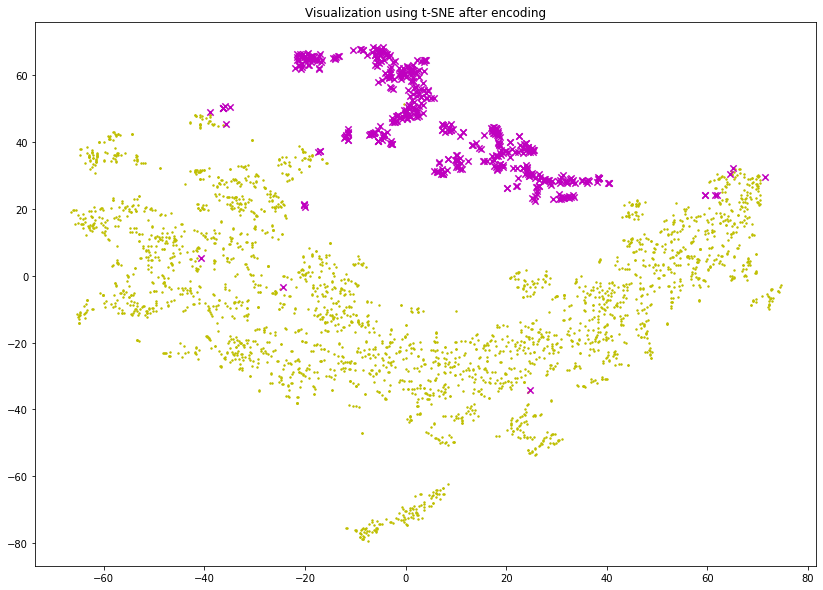

In [0]:
# 코드 4-20 t-SNE를 이용한 특징 표현 데이터 시각화

normal_rep = rep_model.predict(x_normal)
fraud_rep = rep_model.predict(x_fraud)

x_rep = np.append(normal_rep, fraud_rep, axis = 0)
y_normal = np.zeros(normal_rep.shape[0])
y_fraud = np.ones(fraud_rep.shape[0])
y_all = np.append(y_normal, y_fraud)

result_tsne = tsne.fit_transform(x_rep)

fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(result_tsne[:len(y_normal)][:, 1], result_tsne[:len(y_normal)][:, 0],
            s = 2, marker= 'o', c='y')
plt.scatter(result_tsne[len(y_normal):][:, 1], result_tsne[len(y_normal):][:, 0],
            s = 40, marker= 'x', c='m')
plt.title('Visualization using t-SNE after encoding');

## 4.2.5 1%의 데이터로 99% 성능 내기

In [0]:
# 코드 4-21 데이터 추출 및 데이터 분할

x_normal = df[df['Class'] == 0].drop('Class', axis=1).values
x_fraud = df[df['Class'] == 1].drop('Class', axis=1).values

normal_rep = rep_model.predict(x_normal)
fraud_rep = rep_model.predict(x_fraud)

x_rep = np.append(normal_rep, fraud_rep, axis = 0)
y_normal = np.zeros(normal_rep.shape[0])
y_fraud = np.ones(fraud_rep.shape[0])
y_all = np.append(y_normal, y_fraud)

x_train, x_test, y_train, y_test = train_test_split(x_rep, y_all, test_size=0.99)

In [0]:
# 코드 4-22 분류 모델 생성 및 학습

def create_classifier(input_shape):
  inputs = Input(shape=(input_shape,))
  
  fc_1 = Dense(32, kernel_initializer='he_normal', activation='relu')(inputs)
  fc_2 = Dense(16, kernel_initializer='he_normal', activation='relu')(fc_1)
  outputs = Dense(1, activation='sigmoid')(fc_2)

  model = Model(inputs, outputs)

  return model

classifier = create_classifier(REP_DIM)
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
classifier.fit(x_train, y_train, batch_size=256, epochs=5, validation_split=0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2278 samples, validate on 570 samples
Epoch 1/5
2278/2278 [==============================] - 0s 156us/step - loss: 0.1019 - acc: 0.9947 - val_loss: 0.0538 - val_acc: 0.9982
Epoch 2/5
2278/2278 [==============================] - 0s 9us/step - loss: 0.0436 - acc: 0.9982 - val_loss: 0.0272 - val_acc: 0.9982
Epoch 3/5
2278/2278 [==============================] - 0s 9us/step - loss: 0.0259 - acc: 0.9982 - val_loss: 0.0171 - val_acc: 0.9982
Epoch 4/5
2278/2278 [==============================] - 0s 10us/step - loss: 0.0186 - acc: 0.9982 - val_loss: 0.0127 - val_acc: 0.9982
Epoch 5/5
2278/2278 [==============================] - 0s 10us/step - loss: 0.0151 - acc: 0.9982 - val_loss: 0.0105 - val_acc: 0.9982


In [0]:
# 코드 4-23 분류 모델 성능 평가

classifier.evaluate(x_test, y_test)

281959/281959 [==============================] - 5s 18us/step


[0.017328384180508888, 0.9982727985274454]